# Student ID: 2200846







## Install required libraries

In [1]:
!pip install transformers tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 6.5 MB/s eta 0:00:00


## import all require libraries. 

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from tensorflow.keras.utils import custom_object_scope
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import torch
import datetime
from sklearn import svm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.callbacks import EarlyStopping
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Define my student id as a variable**

In [3]:
student_id = 2200846 # My Student id

## set `seed` for all libraries

In [4]:
# set same seeds for all libraries
print('Setting seed for all librraies...')
np.random.seed(student_id)
seed= student_id
print('done!')

Setting seed for all librraies...
done!


# Common Codes 



## **GDrive access**

In [5]:
# Mount Google Drive
print('mounting GDrive...')
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

mounting GDrive...
Mounted at /content/gdrive


## **Set global variables**


*   Set data and model path
*   Splitting the original dataset into 4 subsets - [25%, 50%, 75%, 100%]



In [12]:
print('All the directories and global variables are defined-->')

# Defining the Paths
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./CE807/Assignment2/', str(student_id))
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('Google Drive path: ', GOOGLE_DRIVE_PATH)

# Check the contents of the Google Drive directory
print('Contents of Google Drive directory:')
print(os.listdir(GOOGLE_DRIVE_PATH))

# Load the training dataset from a CSV file
train_100_file = os.path.join(GOOGLE_DRIVE_PATH, 'train.csv')
df = pd.read_csv(train_100_file)


# Recursively divide the data into four splits
def recursive_split(df, seed):
    """
    Recursively splits a dataset into sizes of [25%, 50%, 75%, and 100%]
    while maintaining the class distribution of the original dataset.

    Args:
        df (pd.DataFrame): The input dataset.
        test_size (float): The size of the test set in each split. Default: 0.25.

    Returns:
        A dictionary containing the 4 splits of the dataset.
    """
    # Separate the DataFrame into positive and negative classes
    pos_df = df[df['label'] == 'OFF']
    neg_df = df[df['label'] == 'NOT']

    # Shuffle the positive and negative classes separately
    pos = pos_df.sample(frac=1, random_state=seed)
    neg = neg_df.sample(frac=1, random_state=seed)

    # Define the sizes of the subsets
    subset_sizes = [0.25, 0.5, 0.75, 1.0]

    # Initialize lists to store the resulting subsets
    subsets = [[] for _ in subset_sizes]

    # Loop through the subsets
    for i, subset_size in enumerate(subset_sizes):
        # Calculate the number of positive and negative examples in the subset
        pos_subset_size = int(np.ceil(subset_size * len(pos)))
        neg_subset_size = int(np.ceil(subset_size * len(neg)))

        # Extract the positive and negative examples for the subset
        pos_subset = pos_df[:pos_subset_size]
        neg_subset = neg_df[:neg_subset_size]

        # Concatenate the positive and negative subsets
        subset = pd.concat([pos_subset, neg_subset])

        # Shuffle the subset
        subset = subset.sample(frac=1, random_state=seed)

        # Store the resulting subset in the corresponding list
        subsets[i] = subset
    train_25, train_50, train_75, train_100 = subsets

    return train_25, train_50, train_75, train_100

# function usage
# Assign the resulting subsets to separate variables
train_25, train_50, train_75, train_100 = recursive_split(df, seed)

# Verify that the class distributions are maintained
# Calculate and print the class distribution for each split
print('Original dataset class distribution:')
print(df['label'].value_counts(normalize=True))
print('Total Count : ', len(df.index))
print()

print('Train Dataset Statistics of Different Size :')
table1 = [['25%', len(train_25.index), (train_25['label'].value_counts(normalize=True)['OFF'])*100, (train_25['label'].value_counts(normalize=True)['NOT'])*100],
          ['50%', len(train_50.index), (train_50['label'].value_counts(normalize=True)['OFF'])*100, (train_50['label'].value_counts(normalize=True)['NOT'])*100],
          ['75%', len(train_75.index), (train_75['label'].value_counts(normalize=True)['OFF'])*100, (train_75['label'].value_counts(normalize=True)['NOT'])*100],
          ['100%', len(df.index), (df['label'].value_counts(normalize=True)['OFF'])*100, (df['label'].value_counts(normalize=True)['NOT'])*100]]
print(tabulate(table1, headers=['Data %', 'Total', '% OFF', '% NOT'], tablefmt='orgtbl'))
print('\n')

print('Saving the files=============>')
# Save the divided subsets to CSV files
train_25_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_25.csv')
train_25.to_csv(train_25_file, index=False)
print('Saved 25% of the training data to :', train_25_file)

train_50_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_50.csv')
train_50.to_csv(train_50_file, index=False)
print('Saved 50% of the training data to :', train_50_file)

train_75_file = os.path.join(GOOGLE_DRIVE_PATH, 'train_75.csv')
train_75.to_csv(train_75_file, index=False)
print('Saved 75% of the training data to :', train_75_file)

print('100% of the training data :', train_100_file)

print('\n')
# Load the validation and test datasets from CSV files
val_file = os.path.join(GOOGLE_DRIVE_PATH, 'valid.csv')
print('Validation data :', val_file)
print(pd.read_csv(val_file)['label'].value_counts(normalize=True))
print('Total Count : ', len(pd.read_csv(val_file).index))
print()
print('\n')
test_file = os.path.join(GOOGLE_DRIVE_PATH, 'test.csv')
print('Test data :', test_file)
print(pd.read_csv(test_file)['label'].value_counts(normalize=True))
print('Total Count : ', len(pd.read_csv(test_file).index))
print()

print('\n')
print('='*50)
print('=====================Model 1=====================')
print('\n')

MODEL_1_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '1') # Model 1 directory
print('Model 1 directory: ', MODEL_1_DIRECTORY)

MODEL_1_25_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'25') # Model 1 trained using 25% of train data directory
print('Model 1 directory with 25% data: ', MODEL_1_25_DIRECTORY)

model_1_25_output_test_file = os.path.join(MODEL_1_25_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 25% of train data 
print('Output file name using model 1 using 25% of train data: ',model_1_25_output_test_file)

MODEL_1_50_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'50') # Model 1 trained using 50% of train data directory
print('Model 1 directory with 50% data: ', MODEL_1_50_DIRECTORY)

model_1_50_output_test_file = os.path.join(MODEL_1_50_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 50% of train data 
print('Output file name using model 1 using 50% of train data: ',model_1_50_output_test_file)

MODEL_1_75_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'75') # Model 1 trained using 75% of train data directory
print('Model 1 directory with 75% data: ', MODEL_1_75_DIRECTORY)

model_1_75_output_test_file = os.path.join(MODEL_1_75_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 75% of train data 
print('Output file name using model 1 using 75% of train data: ',model_1_75_output_test_file)

MODEL_1_100_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'100') # Model 1 trained using 100% of train data directory
print('Model 1 directory with 100% data: ', MODEL_1_100_DIRECTORY)

model_1_100_output_test_file = os.path.join(MODEL_1_100_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 100% of train data 
print('Output file name using model 1 using 100% of train data: ',model_1_100_output_test_file)

print('\n')
print('='*50)
print('=====================Model 2=====================')
print('\n')

MODEL_2_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '2') # Model 2 directory
print('Model 2 directory: ', MODEL_2_DIRECTORY)

MODEL_2_25_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'25') # Model 2 trained using 25% of train data directory
print('Model 2 directory with 25% data: ', MODEL_2_25_DIRECTORY)

model_2_25_output_test_file = os.path.join(MODEL_2_25_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 25% of train data 
print('Output file name using model 2 using 25% of train data: ',model_2_25_output_test_file)

MODEL_2_50_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'50') # Model 2 trained using 50% of train data directory
print('Model 2 directory with 50% data: ', MODEL_2_50_DIRECTORY)

model_2_50_output_test_file = os.path.join(MODEL_2_50_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 50% of train data 
print('Output file name using model 2 using 50% of train data: ',model_2_50_output_test_file)

MODEL_2_75_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'75') # Model 2 trained using 75% of train data directory
print('Model 2 directory with 75% data: ', MODEL_2_75_DIRECTORY)

model_2_75_output_test_file = os.path.join(MODEL_2_75_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 75% of train data 
print('Output file name using model 2 using 75% of train data: ',model_2_75_output_test_file)

MODEL_2_100_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'100') # Model 2 trained using 100% of train data directory
print('Model 2 directory with 100% data: ', MODEL_2_100_DIRECTORY)

model_2_100_output_test_file = os.path.join(MODEL_2_100_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 100% of train data 
print('Output file name using model 2 using 100% of train data: ',model_2_100_output_test_file)

print('\n')
print('='*50)
print('=====================Model 3=====================')
print('\n')

MODEL_3_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '3') # Model 3 directory
print('Model 3 directory: ', MODEL_3_DIRECTORY)

MODEL_3_25_DIRECTORY = os.path.join(MODEL_3_DIRECTORY,'25') # Model 3 trained using 25% of train data directory
print('Model 3 directory with 25% data: ', MODEL_3_25_DIRECTORY)

model_3_25_output_test_file = os.path.join(MODEL_3_25_DIRECTORY, 'output_test.csv') # Output file using Model 3 trained using 25% of train data 
print('Output file name using model 3 using 25% of train data: ',model_3_25_output_test_file)

MODEL_3_50_DIRECTORY = os.path.join(MODEL_3_DIRECTORY,'50') # Model 3 trained using 50% of train data directory
print('Model 3 directory with 50% data: ', MODEL_3_50_DIRECTORY)

model_3_50_output_test_file = os.path.join(MODEL_3_50_DIRECTORY, 'output_test.csv') # Output file using Model 3 trained using 50% of train data 
print('Output file name using model 3 using 50% of train data: ',model_3_50_output_test_file)

MODEL_3_75_DIRECTORY = os.path.join(MODEL_3_DIRECTORY,'75') # Model 3 trained using 75% of train data directory
print('Model 3 directory with 75% data: ', MODEL_3_75_DIRECTORY)

model_3_75_output_test_file = os.path.join(MODEL_3_75_DIRECTORY, 'output_test.csv') # Output file using Model 3 trained using 75% of train data 
print('Output file name using model 3 using 75% of train data: ',model_3_75_output_test_file)

MODEL_3_100_DIRECTORY = os.path.join(MODEL_3_DIRECTORY,'100') # Model 3 trained using 100% of train data directory
print('Model 3 directory with 100% data: ', MODEL_3_100_DIRECTORY)

model_3_100_output_test_file = os.path.join(MODEL_3_100_DIRECTORY, 'output_test.csv') # Output file using Model 3 trained using 100% of train data 
print('Output file name using model 3 using 100% of train data: ',model_3_100_output_test_file)

All the directories and global variables are defined-->
Google Drive path:  gdrive/MyDrive/./CE807/Assignment2/2200846
Contents of Google Drive directory:
['code.ipynb', 'test.csv', 'valid.csv', 'train.csv', '.ipynb_checkpoints', 'models', 'train_25.csv', 'train_50.csv', 'train_75.csv']
Original dataset class distribution:
NOT    0.667668
OFF    0.332332
Name: label, dtype: float64
Total Count :  12313

Train Dataset Statistics of Different Size :
| Data %   |   Total |   % OFF |   % NOT |
|----------+---------+---------+---------|
| 25%      |    3079 | 33.2251 | 66.7749 |
| 50%      |    6157 | 33.2305 | 66.7695 |
| 75%      |    9235 | 33.2323 | 66.7677 |
| 100%     |   12313 | 33.2332 | 66.7668 |


Saving the files=============>
Saved 25% of the training data to : gdrive/MyDrive/./CE807/Assignment2/2200846/train_25.csv
Saved 50% of the training data to : gdrive/MyDrive/./CE807/Assignment2/2200846/train_50.csv
Saved 75% of the training data to : gdrive/MyDrive/./CE807/Assignment2/22

## **Exploring the dataset file**

EDA of the training dataset :
      id                                              tweet label
0  42884  @USER I’m done with you as well. An INTENTIONA...   NOT
1  92152  I now have over 6k followers.  Only 94k to go ...   NOT
2  65475  @USER Tom was bought! He is more interested in...   NOT
3  22144  @USER @USER Even her brother thinks she is a m...   OFF
4  81048  @USER @USER @USER @USER @USER I can understand...   OFF


Shape of the dataset :
(12313, 3)


Check missing values :
id       0
tweet    0
label    0
dtype: int64


descriptive statistics for the dataset :
                 id
count  12313.000000
mean   54937.978640
std    26079.349786
min    10006.000000
25%    32275.000000
50%    54953.000000
75%    77777.000000
max    99986.000000


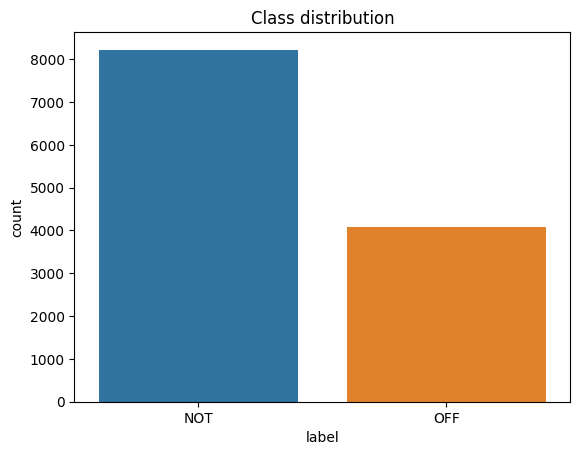



Label Count Distribution :
No. of tweets Offensive (OFF) are 4092
No. of tweets Not Offensive (NOT) are 8221


In [13]:
print('EDA of the training dataset :')
print(df.head())
print('\n')

# Print the shape of the dataset
print('Shape of the dataset :')
print(df.shape)
print('\n')

# Check for missing values
print('Check missing values :')
print(df.isna().sum())
print('\n')

# Print descriptive statistics for the dataset
print('descriptive statistics for the dataset :')
print(df.describe())

# Plot the distribution of classes
sns.countplot(x='label', data=df)
plt.title('Class distribution')
plt.show()
print('\n')

print('Label Count Distribution :')
print('No. of tweets Offensive (OFF) are', len(df[df.label=='OFF']))
print('No. of tweets Not Offensive (NOT) are', len(df[df.label=='NOT']))

## Functions

In [14]:
def compute_performance(y_true, y_pred):
    """
    Computes performance metrics and displays them in a table.

    Args:
        y_true: numpy array or list - true labels
        y_pred: numpy array or list - predicted labels

    Returns:
        float - F1 score
    """
    # Calculate performance metrics
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    pre = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Create table
    table = [['Accuracy', round(acc, 4)],
             ['Recall', round(rec, 4)],
             ['Precision', round(pre, 4)],
             ['F1 Score', round(f1, 4)]]

    # Print table
    print(tabulate(table, headers=['Metric', 'Value'], tablefmt='orgtbl'))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Return F1 score
    return f1

In [15]:
def clean_text(data):
    """
    Preprocesses the training, testing, and validation data by nltk

    Args:
        data (str): The path to the data file.

    Returns:
        tuple: A tuple containing the preprocessed training, testing, and validation data, as well
            as the vectorizer.
    """
    # Load the data from the files
    # Tokenize the text data using NLTK
    data['tweet'] = data['tweet'].apply(lambda x: word_tokenize(x))

    # Remove stop words using NLTK
    stop_words = set(stopwords.words('english'))
    data['tweet'] = data['tweet'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

    # Combine the tokenized text data back into strings
    data['tweet'] = data['tweet'].apply(lambda x: ' '.join(x))
    return data

In [16]:
def vectorizing(train_file):
    """
    Vectorizing the text data in the training file using TfidfVectorizer. Save the vectorizer

    Args:
        train_file (str): The path to the training data file.

    Returns:
        tuple: A tuple containing the preprocessed training and as well as the vectorizer.
    """

    # Vectorize the text data using TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_file["tweet"])
    y_train = train_file["label"]
    return X_train, y_train, vectorizer

# Method 1 Start


**This method, preprocesse the data with NLTK and TFIDF vectorizer and trains a Support Vector Machine (SVM) model.**

## Training Method 1 Code


In [17]:
def train_method1(train_file, val_file, model_dir):
    """
    Trains a Support Vector Machine model using the preprocessed training data and saves the
    trained model to disk. Prints computed evaluation matrics

    Args:
        train_file (str): The path to the preprocessed training data file.
        val_file (str): The path to the preprocessed validation data file.
        model_dir (str): The path to the directory where the trained model will be saved.
    """

    print('========================TRAINING METHOD 1========================')
    # Load the dataset
    train_data = pd.read_csv(train_file)
    val_data = pd.read_csv(val_file)

    # Clean the data
    train_data = clean_text(train_data)
    val_data = clean_text(val_data)

    # Vectorize the data
    X_train, y_train, vectorizer = vectorizing(train_data)
    vec_path = os.path.join(model_dir, "vec.sav")
    joblib.dump(vectorizer, vec_path)

    X_val = vectorizer.transform(val_data['tweet'])
    y_val = val_data['label']



    # Train a Support Vector Machine model
    model = svm.SVC()
    model.fit(X_train, y_train)

    # Save the trained model to disk
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = os.path.join(model_dir, "model.sav")
    joblib.dump(model, model_path)

    # Predict on the validation set
    y_pred_val = model.predict(X_val)

      
    print('\n')
    print('Evaluation------------->')
    compute_performance(y_val, y_pred_val)


    print(f"Model saved to {model_path}")

    return


## Testing Method 1 Code

In [18]:
def test_method1(test_file, model_file, output_dir):
    """
    Loads a trained model from disk and evaluates it on the test data. Saves the
    classification report to disk.

    Args:
        test_file (str): The path to the preprocessed test data file.
        model_file (str): The path to the trained model file.
        output_dir (str): The path to the directory where the classification report will be saved.
    """
    print('========================TESTING METHOD 1========================')

    # Load test data
    test_data = pd.read_csv(test_file)
    
    # Load the trained model and vectorizer
    model = joblib.load(os.path.join(model_file, "model.sav"))
    vectorizer = joblib.load(os.path.join(model_file, "vec.sav"))

    # Preprocess the test data
    test_data = clean_text(test_data)

    # Vectorize the data
    X_test = vectorizer.transform(test_data['tweet'])
    y_test = test_data['label']

    # Make predictions on the test data
    y_pred_test = model.predict(X_test)

    print('\n')
    print('Evaluation------------->')
    # Compute Evaluation Matrics
    compute_performance(y_test, y_pred_test)


    # Save predictions to output file
    test_data['out_label'] = y_pred_test
    test_data.to_csv(output_dir, index=False)
    print(test_data)
    print("Testing completed successfully!")
    return 

**Implementing the functions**

=====Training on 25% of the dataset=====
========================TRAINING METHOD 1========================


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.7238 |
| Recall    |  0.5966 |
| Precision |  0.7659 |
| F1 Score  |  0.5844 |


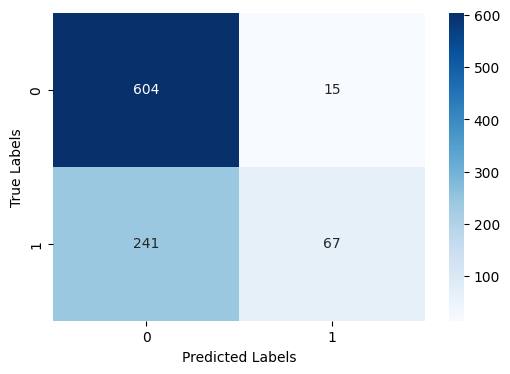

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/1/25/model.sav




=====Training on 50% of the dataset=====
========================TRAINING METHOD 1========================


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.74   |
| Recall    |  0.6275 |
| Precision |  0.7643 |
| F1 Score  |  0.6297 |


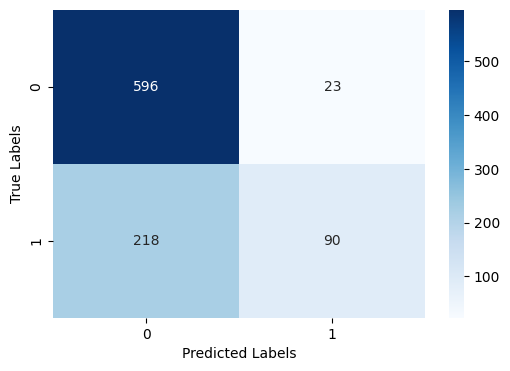

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/1/50/model.sav




=====Training on 75% of the dataset=====
========================TRAINING METHOD 1========================


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.7508 |
| Recall    |  0.6487 |
| Precision |  0.7651 |
| F1 Score  |  0.6574 |


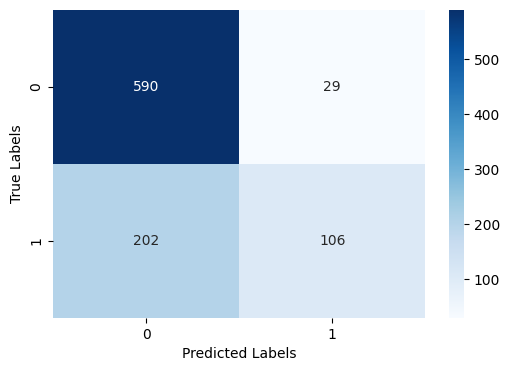

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/1/75/model.sav




=====Training on 100% of the dataset=====
========================TRAINING METHOD 1========================


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.7508 |
| Recall    |  0.6535 |
| Precision |  0.7553 |
| F1 Score  |  0.6636 |


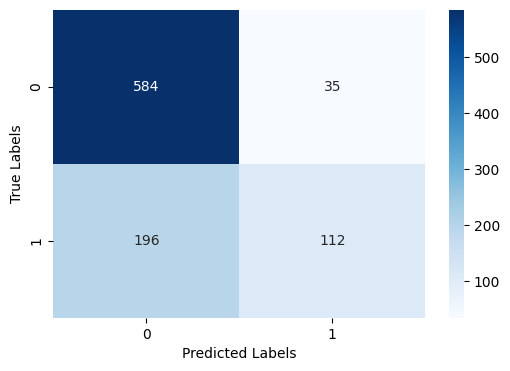

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/1/100/model.sav






In [19]:
training_data = [
    (train_25_file, MODEL_1_25_DIRECTORY, model_1_25_output_test_file, '25%'),
    (train_50_file, MODEL_1_50_DIRECTORY, model_1_50_output_test_file, '50%'),
    (train_75_file, MODEL_1_75_DIRECTORY, model_1_75_output_test_file, '75%'),
    (train_100_file, MODEL_1_100_DIRECTORY, model_1_100_output_test_file, '100%')
]

for data in training_data:
    train_file, model_dir, output_file, data_label = data
    print(f'=====Training on {data_label} of the dataset=====')
    train_method1(train_file, val_file, model_dir)
    print('\n')
    print('='*100)
    print('\n')

**The best model was when trained and evaluated on 25% training dataset**

========================TESTING METHOD 1========================


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.7826 |
| Recall    |  0.6194 |
| Precision |  0.8343 |
| F1 Score  |  0.6293 |


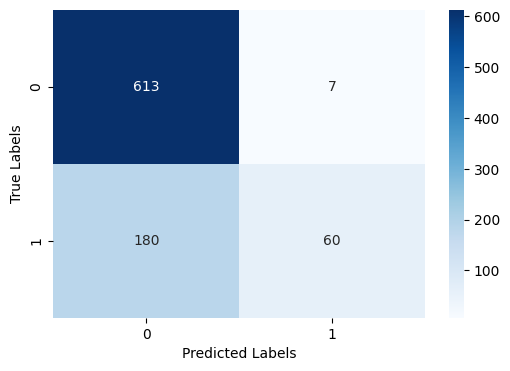

        id                                              tweet label out_label
0    15923  # WhoIsQ # WheresTheServer # DumpNike # DECLAS...   OFF       NOT
1    27014  # ConstitutionDay revered Conservatives , hate...   NOT       NOT
2    30530  # FOXNews # NRA # MAGA # POTUS # TRUMP # 2ndAm...   NOT       NOT
3    13876  # Watching # Boomer getting news still parole ...   NOT       NOT
4    60133  # NoPasaran : Unity demo oppose far-right # Lo...   OFF       NOT
..     ...                                                ...   ...       ...
855  73439  # DespicableDems lie rifles . Dem Distorted La...   OFF       NOT
856  25657  # MeetTheSpeakers 🙌 @ USER present event OIW 2...   NOT       NOT
857  67018  3 people unfollowed talking merlin sorry y'all...   OFF       OFF
858  50665  # WednesdayWisdom Antifa calls right fascist ,...   NOT       NOT
859  24583   # Kavanaugh typical # liberals , # Democrats URL   NOT       NOT

[860 rows x 4 columns]
Testing completed successfully!


In [20]:
# testing on entire dataset
test_method1(test_file, MODEL_1_25_DIRECTORY, model_1_25_output_test_file)

## Method 1 End


# Method 2 Start



**This method preprocess the data with NLTK and TensorFlow's tokenizer and trains a BiLSTM model**

## Training Method 2 Code


In [21]:
def train_method2(train_file, val_file, model_dir):
    """
    The function loads the training and validation data, cleans the data using NLTK, tokenizes it TensorFlow’s tokenizer, 
    and pads the sequences to ensure they are all the same length. 
    It also converts the labels to one-hot vectors.
    Trains a Bidirectional LSTM model using the training data and saves the
    trained model to disk.

    Args:
        train_file (str): The path to the preprocessed training data file.
        val_file (str): The path to the preprocessed validation data file.
        model_dir (str): The path to the directory where the trained model will be saved.
    """

    print('========================TRAINING METHOD 2========================')
    # Load the dataset
    train_data = pd.read_csv(train_file)
    val_data = pd.read_csv(val_file)

    # Clean the data
    train_data = clean_text(train_data)
    val_data = clean_text(val_data)

    # Tokenize the data
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(train_data['tweet'])
    X_train = tokenizer.texts_to_sequences(train_data['tweet'])
    X_val = tokenizer.texts_to_sequences(val_data['tweet'])

    # Pad sequences
    max_len =100
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_val = pad_sequences(X_val, maxlen=max_len)

    # Convert labels to one-hot vectors
    y_train = pd.get_dummies(train_data['label']).values
    y_val = pd.get_dummies(val_data['label']).values

    # Define the model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(units=64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(units=32)),
        Dropout(0.2),
        Dense(units=2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    # Save the trained model to disk
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = os.path.join(model_dir, "model.h5")
    joblib.dump(model, model_path)

    # Save the tokenizer to disk
    tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
    joblib.dump(tokenizer, tokenizer_path)

    # Evaluate the model
    y_pred_val = model.predict(X_val)
    y_pred_val = y_pred_val.argmax(axis=1)
    y_val = y_val.argmax(axis=1)
    
    # Compute performance metrics
    print('\n')
    print('Evaluation------------->')
    compute_performance(y_val, y_pred_val)

    print(f"Model saved to {model_path}")



    return

## Testing Method 2 Code

In [22]:
def test_method2(test_file, model_file, output_dir):
    """
      take test_file, model_file and output_dir as input.
      It loads model and test of the examples in the test_file.
      It prints different evaluation metrics, and saves the output in output directory

      ADD Other arguments, if needed

    Args:
        test_file: test file name
        model_file: model file name
        output_dir: Output Directory
        

    
    """
    print('\n')
    print('========================TESTING METHOD 2========================')
    # Load test data
    test_data = pd.read_csv(test_file)

    # Clean the test data
    test_data = clean_text(test_data)
    
    # Load the trained model and vectorizer
    model = joblib.load(os.path.join(model_file, "model.h5"))
    tokenizer = joblib.load(os.path.join(model_file, "tokenizer.pkl"))

    # Tokenize the data
    X_test = tokenizer.texts_to_sequences(test_data['tweet'])

    # Pad sequences
    max_len = 100
    X_test = pad_sequences(X_test, maxlen=max_len)


    # Make predictions on the test data
    y_pred_test = model.predict(X_test)
    y_pred_test = y_pred_test.argmax(axis=1)
    y_test = pd.get_dummies(test_data['label']).values.argmax(axis=1)

    # Compute evaluation matrics
    print('\n')
    print('Evaluation------------->')
    compute_performance(y_test, y_pred_test)


    # Save predictions to output file
    y_pred_test = np.where(y_pred_test==1, 'OFF', 'NOT') # Convert back to 'NOT' and 'OFF
    test_data['out_label'] = y_pred_test
    test_data.to_csv(output_dir, index=False)
    print(test_data)
    print("Testing completed successfully!")

    return

=====Training on 25% of the dataset=====
========================TRAINING METHOD 2========================
Epoch 1/10
97/97 [==============================] - 34s 220ms/step - loss: 0.6204 - accuracy: 0.6687 - val_loss: 0.6214 - val_accuracy: 0.6893
Epoch 2/10
97/97 [==============================] - 8s 79ms/step - loss: 0.3580 - accuracy: 0.8493 - val_loss: 0.6001 - val_accuracy: 0.7206
Epoch 3/10
97/97 [==============================] - 8s 79ms/step - loss: 0.1272 - accuracy: 0.9630 - val_loss: 0.8742 - val_accuracy: 0.6915
Epoch 4/10
97/97 [==============================] - 4s 47ms/step - loss: 0.0508 - accuracy: 0.9847 - val_loss: 0.9770 - val_accuracy: 0.7174
Epoch 5/10
97/97 [==============================] - 4s 43ms/step - loss: 0.0389 - accuracy: 0.9909 - val_loss: 1.2278 - val_accuracy: 0.7152
Epoch 6/10
97/97 [==============================] - 4s 46ms/step - loss: 0.0307 - accuracy: 0.9919 - val_loss: 1.2638 - val_accuracy: 0.7044
Epoch 7/10
97/97 [===========================

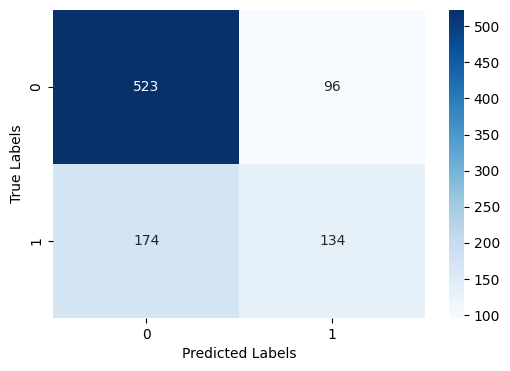

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/2/25/model.h5




=====Training on 50% of the dataset=====
========================TRAINING METHOD 2========================
Epoch 1/10
193/193 [==============================] - 30s 112ms/step - loss: 0.5975 - accuracy: 0.6919 - val_loss: 0.5304 - val_accuracy: 0.7487
Epoch 2/10
193/193 [==============================] - 11s 54ms/step - loss: 0.3641 - accuracy: 0.8478 - val_loss: 0.5860 - val_accuracy: 0.7540
Epoch 3/10
193/193 [==============================] - 5s 28ms/step - loss: 0.1964 - accuracy: 0.9311 - val_loss: 0.7481 - val_accuracy: 0.7346
Epoch 4/10
193/193 [==============================] - 7s 37ms/step - loss: 0.1089 - accuracy: 0.9641 - val_loss: 0.9100 - val_accuracy: 0.7184
Epoch 5/10
193/193 [==============================] - 5s 25ms/step - loss: 0.0661 - accuracy: 0.9818 - val_loss: 1.1540 - val_accuracy: 0.7001
Epoch 6/10
193/193 [==============================] - 5s 28ms/step - loss: 0.0464 - accuracy

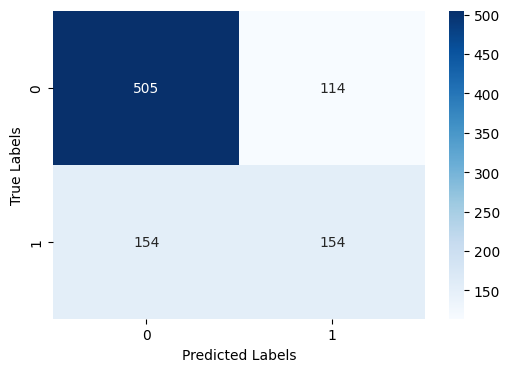

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/2/50/model.h5




=====Training on 75% of the dataset=====
========================TRAINING METHOD 2========================
Epoch 1/10
289/289 [==============================] - 36s 98ms/step - loss: 0.5745 - accuracy: 0.7112 - val_loss: 0.5119 - val_accuracy: 0.7638
Epoch 2/10
289/289 [==============================] - 12s 41ms/step - loss: 0.3769 - accuracy: 0.8391 - val_loss: 0.5614 - val_accuracy: 0.7551
Epoch 3/10
289/289 [==============================] - 6s 22ms/step - loss: 0.2350 - accuracy: 0.9112 - val_loss: 0.6289 - val_accuracy: 0.7508
Epoch 4/10
289/289 [==============================] - 8s 27ms/step - loss: 0.1383 - accuracy: 0.9542 - val_loss: 0.8713 - val_accuracy: 0.7346
Epoch 5/10
289/289 [==============================] - 6s 21ms/step - loss: 0.0879 - accuracy: 0.9707 - val_loss: 1.1179 - val_accuracy: 0.7141
Epoch 6/10
289/289 [==============================] - 8s 28ms/step - loss: 0.0613 - accuracy:

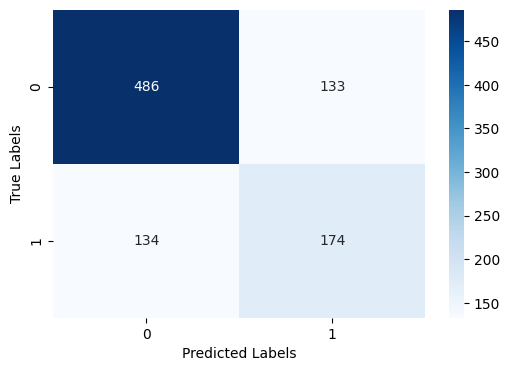

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/2/75/model.h5




=====Training on 100% of the dataset=====
========================TRAINING METHOD 2========================
Epoch 1/10
385/385 [==============================] - 37s 79ms/step - loss: 0.5562 - accuracy: 0.7236 - val_loss: 0.5200 - val_accuracy: 0.7616
Epoch 2/10
385/385 [==============================] - 12s 30ms/step - loss: 0.3805 - accuracy: 0.8428 - val_loss: 0.5522 - val_accuracy: 0.7584
Epoch 3/10
385/385 [==============================] - 10s 26ms/step - loss: 0.2524 - accuracy: 0.9034 - val_loss: 0.6354 - val_accuracy: 0.7389
Epoch 4/10
385/385 [==============================] - 9s 23ms/step - loss: 0.1678 - accuracy: 0.9409 - val_loss: 0.7845 - val_accuracy: 0.7152
Epoch 5/10
385/385 [==============================] - 9s 24ms/step - loss: 0.1120 - accuracy: 0.9599 - val_loss: 1.1341 - val_accuracy: 0.7098
Epoch 6/10
385/385 [==============================] - 10s 25ms/step - loss: 0.0795 - accura

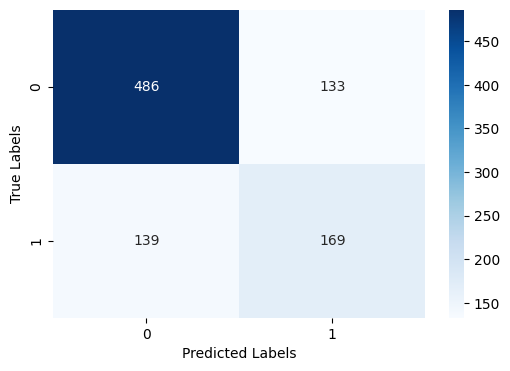

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/2/100/model.h5






In [23]:
training_data = [
    (train_25_file, MODEL_2_25_DIRECTORY, model_2_25_output_test_file, '25%'),
    (train_50_file, MODEL_2_50_DIRECTORY, model_2_50_output_test_file, '50%'),
    (train_75_file, MODEL_2_75_DIRECTORY, model_2_75_output_test_file, '75%'),
    (train_100_file, MODEL_2_100_DIRECTORY, model_2_100_output_test_file, '100%')
]

for data in training_data:
    train_file, model_dir, output_file, data_label = data
    print(f'=====Training on {data_label} of the dataset=====')
    train_method2(train_file, val_file, model_dir)
    print('\n')
    print('='*100)
    print('\n')

**The best model was when trained and evaluated on 75% of training data**



========================TESTING METHOD 2========================
27/27 [==============================] - 2s 10ms/step


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.743  |
| Recall    |  0.6762 |
| Precision |  0.6795 |
| F1 Score  |  0.6778 |


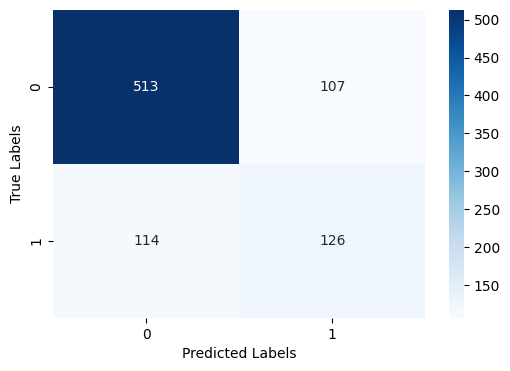

        id                                              tweet label out_label
0    15923  # WhoIsQ # WheresTheServer # DumpNike # DECLAS...   OFF       OFF
1    27014  # ConstitutionDay revered Conservatives , hate...   NOT       NOT
2    30530  # FOXNews # NRA # MAGA # POTUS # TRUMP # 2ndAm...   NOT       OFF
3    13876  # Watching # Boomer getting news still parole ...   NOT       NOT
4    60133  # NoPasaran : Unity demo oppose far-right # Lo...   OFF       NOT
..     ...                                                ...   ...       ...
855  73439  # DespicableDems lie rifles . Dem Distorted La...   OFF       NOT
856  25657  # MeetTheSpeakers 🙌 @ USER present event OIW 2...   NOT       NOT
857  67018  3 people unfollowed talking merlin sorry y'all...   OFF       NOT
858  50665  # WednesdayWisdom Antifa calls right fascist ,...   NOT       OFF
859  24583   # Kavanaugh typical # liberals , # Democrats URL   NOT       NOT

[860 rows x 4 columns]
Testing completed successfully!


In [24]:
# testing on entire dataset
test_method2(test_file, MODEL_2_100_DIRECTORY, model_2_100_output_test_file)

## Method 2 End


# Method 3


**This method preprocesse the data using NLTK and TFIDF Vectorizer and trains a BiLSTM model**

## Training Method 3 code

In [25]:
def train_method3(train_file, val_file, model_dir):
    """
    Trains a Convolutional Neural Network (CNN) model on the given training dataset, validates it on the given validation
    dataset, saves the trained model, and prints the classification report.

    Args:
        train_file: str, the path of the training dataset file
        val_file: str, the path of the validation dataset file
        model_dir: str, the path of the directory where the trained model should be saved

    Returns:
        None
    """
    """
    Trains a Support Vector Machine model using the preprocessed training data and saves the
    trained model to disk.

    Args:
        train_file (str): The path to the preprocessed training data file.
        val_file (str): The path to the preprocessed validation data file.
        model_dir (str): The path to the directory where the trained model will be saved.
    """

    print('========================TRAINING METHOD 3========================')
    # Load the dataset
    train_data = pd.read_csv(train_file)
    val_data = pd.read_csv(val_file)

    # Clean the data
    train_data = clean_text(train_data)
    val_data = clean_text(val_data)

    # Vectorize the data
    X_train, y_train, vectorizer = vectorizing(train_data)
    vec_path = os.path.join(model_dir, "vec.sav")
    joblib.dump(vectorizer, vec_path)

    X_val = vectorizer.transform(val_data['tweet'])
    y_val = val_data['label']

    # Pad sequences
    max_len = 100
    X_train = X_train.toarray()
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_val = X_val.toarray()
    X_val = pad_sequences(X_val, maxlen=max_len)

    # Convert labels to one-hot vectors
    y_train = pd.get_dummies(y_train).values
    y_val = pd.get_dummies(y_val).values


    # Define the BiLSTM model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(units=64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(units=32)),
        Dropout(0.2),
        Dense(units=2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


    # Save the trained model to disk
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = os.path.join(model_dir, "model.h5")
    joblib.dump(model, model_path)

    # Evaluate the model
    y_pred_val = model.predict(X_val)
    y_pred_val = y_pred_val.argmax(axis=1)
    y_val = y_val.argmax(axis=1)

    
    # Compute evaluation matrics
    print('\n')
    print('Evaluation------------->')
    compute_performance(y_val, y_pred_val)


    print(f"Model saved to {model_path}")

    return

## Testing Method 3 code

In [26]:
def test_method3(test_file, model_file, output_dir):
    """
    Loads a trained model from disk and evaluates it on the test data. Saves the
    output file to disk.

    Args:
        test_file (str): The path to the preprocessed test data file.
        model_file (str): The path to the trained model file.
        output_dir (str): The path to the directory where the classification report will be saved.
    """
    print('\n')
    print('========================TESTING METHOD 3========================')
    # Load test data
    test_data = pd.read_csv(test_file)
    
    # Load the trained model and vectorizer
    model = joblib.load(os.path.join(model_file, "model.h5"))
    vectorizer = joblib.load(os.path.join(model_file, "vec.sav"))

    # Preprocess the test data
    test_data = clean_text(test_data)

    # Vectorize the data
    X_test = vectorizer.transform(test_data['tweet'])
    X_test = X_test.toarray()
    X_test = pad_sequences(X_test, maxlen=100)
    y_test = test_data['label']

    # Convert labels to one-hot vectors
    y_test = pd.get_dummies(y_test).values

    # Make predictions on the test data
    y_pred_test = model.predict(X_test)
    y_pred_test = y_pred_test.argmax(axis=1)
    y_test = y_test.argmax(axis=1)


    # Compute evaluation matrics
    print('\n')
    print('Evaluation------------->')
    compute_performance(y_test, y_pred_test)


    # Save predictions to output file
    y_pred_test = np.where(y_pred_test==1, 'OFF', 'NOT') # Convert back to 'NOT' and 'OFF
    test_data['out_label'] = y_pred_test
    test_data.to_csv(output_dir, index=False)
    print("Testing completed successfully!")
    return 

=====Training on 25% of the dataset=====
========================TRAINING METHOD 3========================
Epoch 1/10
97/97 [==============================] - 13s 43ms/step - loss: 0.6439 - accuracy: 0.6619 - val_loss: 0.6365 - val_accuracy: 0.6677
Epoch 2/10
97/97 [==============================] - 2s 21ms/step - loss: 0.6392 - accuracy: 0.6677 - val_loss: 0.6359 - val_accuracy: 0.6677
Epoch 3/10
97/97 [==============================] - 2s 20ms/step - loss: 0.6392 - accuracy: 0.6677 - val_loss: 0.6395 - val_accuracy: 0.6677
Epoch 4/10
97/97 [==============================] - 2s 23ms/step - loss: 0.6370 - accuracy: 0.6677 - val_loss: 0.6358 - val_accuracy: 0.6677
Epoch 5/10
97/97 [==============================] - 3s 30ms/step - loss: 0.6382 - accuracy: 0.6677 - val_loss: 0.6358 - val_accuracy: 0.6677
Epoch 6/10
97/97 [==============================] - 2s 24ms/step - loss: 0.6379 - accuracy: 0.6677 - val_loss: 0.6383 - val_accuracy: 0.6677
Epoch 7/10
97/97 [============================

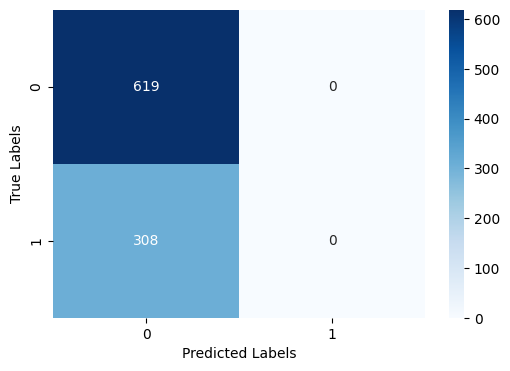

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/3/25/model.h5




=====Training on 50% of the dataset=====
========================TRAINING METHOD 3========================
Epoch 1/10
193/193 [==============================] - 14s 36ms/step - loss: 0.6397 - accuracy: 0.6672 - val_loss: 0.6358 - val_accuracy: 0.6677
Epoch 2/10
193/193 [==============================] - 4s 19ms/step - loss: 0.6372 - accuracy: 0.6677 - val_loss: 0.6380 - val_accuracy: 0.6677
Epoch 3/10
193/193 [==============================] - 4s 19ms/step - loss: 0.6376 - accuracy: 0.6677 - val_loss: 0.6369 - val_accuracy: 0.6677
Epoch 4/10
193/193 [==============================] - 5s 25ms/step - loss: 0.6370 - accuracy: 0.6677 - val_loss: 0.6374 - val_accuracy: 0.6677
Epoch 5/10
193/193 [==============================] - 4s 20ms/step - loss: 0.6380 - accuracy: 0.6677 - val_loss: 0.6442 - val_accuracy: 0.6677
Epoch 6/10
193/193 [==============================] - 4s 18ms/step - loss: 0.6374 - accuracy: 

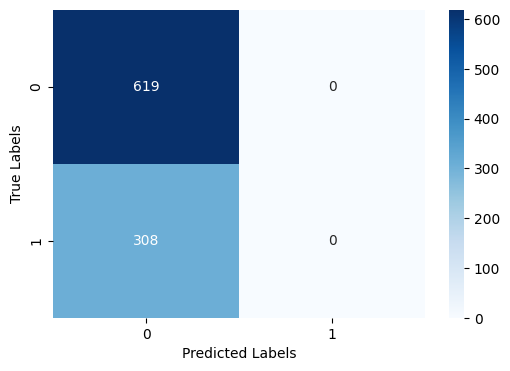

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/3/50/model.h5




=====Training on 75% of the dataset=====
========================TRAINING METHOD 3========================
Epoch 1/10
289/289 [==============================] - 15s 29ms/step - loss: 0.6400 - accuracy: 0.6669 - val_loss: 0.6362 - val_accuracy: 0.6677
Epoch 2/10
289/289 [==============================] - 5s 18ms/step - loss: 0.6372 - accuracy: 0.6677 - val_loss: 0.6360 - val_accuracy: 0.6677
Epoch 3/10
289/289 [==============================] - 7s 23ms/step - loss: 0.6374 - accuracy: 0.6677 - val_loss: 0.6364 - val_accuracy: 0.6677
Epoch 4/10
289/289 [==============================] - 5s 18ms/step - loss: 0.6372 - accuracy: 0.6677 - val_loss: 0.6361 - val_accuracy: 0.6677
Epoch 5/10
289/289 [==============================] - 5s 19ms/step - loss: 0.6370 - accuracy: 0.6677 - val_loss: 0.6359 - val_accuracy: 0.6677
Epoch 6/10
289/289 [==============================] - 7s 23ms/step - loss: 0.6375 - accuracy: 

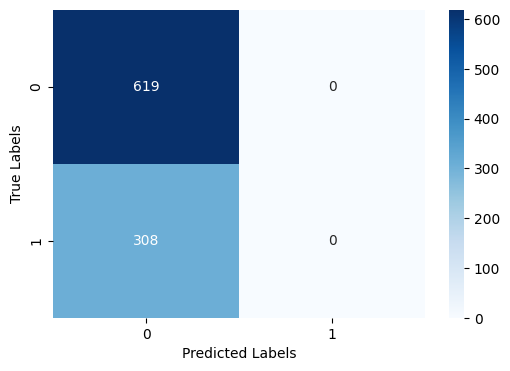

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/3/75/model.h5




=====Training on 100% of the dataset=====
========================TRAINING METHOD 3========================
Epoch 1/10
385/385 [==============================] - 17s 22ms/step - loss: 0.6393 - accuracy: 0.6666 - val_loss: 0.6358 - val_accuracy: 0.6677
Epoch 2/10
385/385 [==============================] - 9s 22ms/step - loss: 0.6375 - accuracy: 0.6677 - val_loss: 0.6364 - val_accuracy: 0.6677
Epoch 3/10
385/385 [==============================] - 7s 18ms/step - loss: 0.6370 - accuracy: 0.6677 - val_loss: 0.6381 - val_accuracy: 0.6677
Epoch 4/10
385/385 [==============================] - 9s 23ms/step - loss: 0.6361 - accuracy: 0.6677 - val_loss: 0.6378 - val_accuracy: 0.6677
Epoch 5/10
385/385 [==============================] - 7s 19ms/step - loss: 0.6370 - accuracy: 0.6677 - val_loss: 0.6360 - val_accuracy: 0.6677
Epoch 6/10
385/385 [==============================] - 8s 21ms/step - loss: 0.6369 - accuracy:

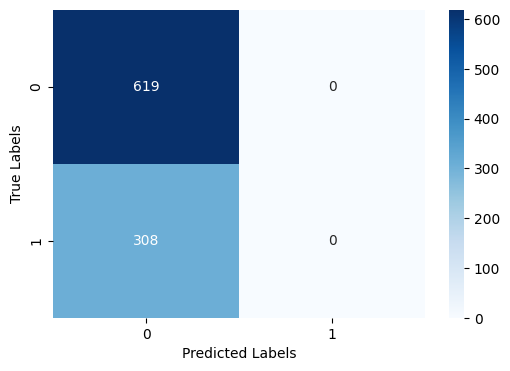

Model saved to gdrive/MyDrive/./CE807/Assignment2/2200846/models/3/100/model.h5






In [27]:
training_data = [
    (train_25_file, MODEL_3_25_DIRECTORY, model_3_25_output_test_file, '25%'),
    (train_50_file, MODEL_3_50_DIRECTORY, model_3_50_output_test_file, '50%'),
    (train_75_file, MODEL_3_75_DIRECTORY, model_3_75_output_test_file, '75%'),
    (train_100_file, MODEL_3_100_DIRECTORY, model_3_100_output_test_file, '100%')
]

for data in training_data:
    train_file, model_dir, output_file, data_label = data
    print(f'=====Training on {data_label} of the dataset=====')
    train_method3(train_file, val_file, model_dir)
    print('\n')
    print('='*100)
    print('\n')

**It was observed that the performance remanined cosistent through out the datasize. So, the model trained on 100% dataset was used for testing.**



========================TESTING METHOD 3========================
27/27 [==============================] - 2s 10ms/step


Evaluation------------->
| Metric    |   Value |
|-----------+---------|
| Accuracy  |  0.7209 |
| Recall    |  0.5    |
| Precision |  0.3605 |
| F1 Score  |  0.4189 |


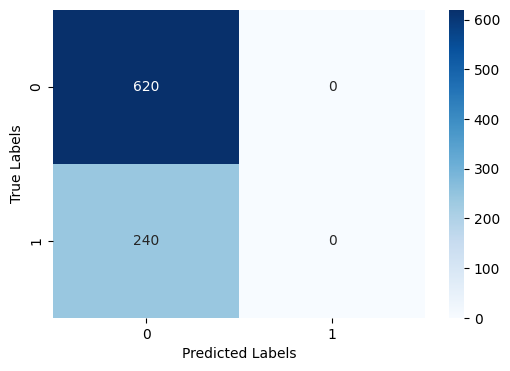

Testing completed successfully!


In [28]:
# testing on entire dataset
test_method3(test_file, MODEL_3_100_DIRECTORY, model_3_100_output_test_file)

##Model 3 End